In [5]:
%matplotlib notebook
%matplotlib inline

# Other
import os
import obspy as ob
import obspy.signal
import random
from matplotlib import cm


from obspy.clients.fdsn import Client
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyasdf
from scipy.fftpack import rfft, irfft
import collections
#from matplotlib.transforms import blended_transform_factory

from beamform_tools import *

plt.style.use('default')
mpl.rc('font', **{'size':20})

### My SALVUS simulation outputs are at discrete gridpoints and discrete azimuths.
### We could make any shape we want here since this is analytic, but for now I'm forcing observations to these gridpoints

In [6]:
outdir = "strainrate_streams"
channel_centers_x = np.load(os.path.join(outdir,"channel_centers_x.npy"))
channel_centers_y = np.load(os.path.join(outdir,"channel_centers_y.npy"))
azis = np.load(os.path.join(outdir,"azis.npy"))

all_stS = np.empty(shape=(len(channel_centers_x),len(channel_centers_y)),dtype='object')
all_stV = np.empty(shape=(len(channel_centers_x),len(channel_centers_y)),dtype='object')
XX = np.zeros(shape=(len(channel_centers_x),len(channel_centers_y)))
YY = np.zeros(shape=(len(channel_centers_x),len(channel_centers_y)))


for ii in range(len(channel_centers_x)):
    for jj in range(len(channel_centers_y)):  
        XX[ii,jj] = channel_centers_x[ii]  # could use np.meshgrid()
        YY[ii,jj] = channel_centers_x[jj]

XX = XX - np.mean(channel_centers_x)
YY = YY - np.mean(channel_centers_y)



### Define the ellipse/circle/etc that we want, and find the nearest possible channel coordinates and azimuths.

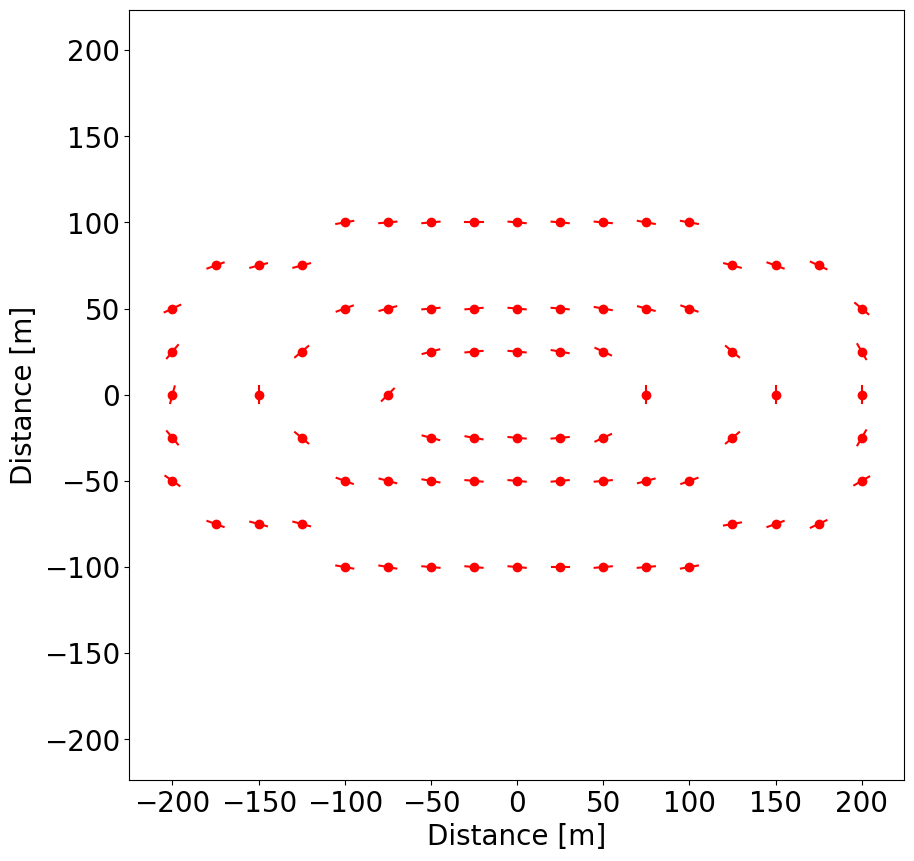

In [10]:
shape = "ellipse"         # ellipse or circle
orientation = "horizontal"  # vertical or horizontal ellipse

# These will hold the indices of the channesl and azimuths we want to pull
use_sta = []
use_azi = []

## CIRCLE
if(shape=="circle"):

    # Define the outermost circle
    rad = 177
    for ang in np.linspace(0,2*np.pi,50):
        x = np.cos(ang)*rad
        y = np.sin(ang)*rad
        dist = (XX-x)**2 + (YY-y)**2
        [ix,iy] = np.unravel_index(np.argmin(dist),np.shape(dist))
        #print(x,y,XX[ix,iy],YY[ix,iy])
        station_code='{:03d}-{:03d}'.format(ix,iy)
        if(station_code not in use_sta):
            use_sta.append(station_code)

            # get the nearest azimuth
            chan_azi = ang+np.pi/2
            # make sure we're not above 180
            if(chan_azi>=np.pi):
                chan_azi-=np.pi
            if(chan_azi>np.pi):
                chan_azi-=np.pi
            iazi = np.argmin(np.abs(azis-chan_azi))
            # pull out the azimuth at this index, 
            # and make sure it's rounded to nearest 5 when converting
            this_azi = int(5 * round( azis[iazi]*180/np.pi )  /5)    
            use_azi.append(this_azi)


    rad = 110
    for ang in np.linspace(0,2*np.pi,25):
        x = np.cos(ang)*rad
        y = np.sin(ang)*rad
        dist = (XX-x)**2 + (YY-y)**2
        [ix,iy] = np.unravel_index(np.argmin(dist),np.shape(dist))
        #print(x,y,XX[ix,iy],YY[ix,iy])
        station_code='{:03d}-{:03d}'.format(ix,iy)
        if(station_code not in use_sta):
            use_sta.append(station_code)

            # get the nearest azimuth
            chan_azi = ang+np.pi/2
            # make sure we're not above 180
            if(chan_azi>=np.pi):
                chan_azi-=np.pi
            if(chan_azi>np.pi):
                chan_azi-=np.pi
            iazi = np.argmin(np.abs(azis-chan_azi))
            # pull out the azimuth at this index, 
            # and make sure it's rounded to nearest 5 when converting
            this_azi = int(5 * round( azis[iazi]*180/np.pi )  /5)    
            use_azi.append(this_azi)


    rad = 30
    for ang in np.linspace(0,2*np.pi,9):
        x = np.cos(ang)*rad
        y = np.sin(ang)*rad
        dist = (XX-x)**2 + (YY-y)**2
        [ix,iy] = np.unravel_index(np.argmin(dist),np.shape(dist))
        #print(x,y,XX[ix,iy],YY[ix,iy])
        station_code='{:03d}-{:03d}'.format(ix,iy)
        if(station_code not in use_sta):
            use_sta.append(station_code)

            # get the nearest azimuth
            chan_azi = ang+np.pi/2
            # make sure we're not above 180
            if(chan_azi>=np.pi):
                chan_azi-=np.pi
            if(chan_azi>np.pi):
                chan_azi-=np.pi
            iazi = np.argmin(np.abs(azis-chan_azi))
            # pull out the azimuth at this index, 
            # and make sure it's rounded to nearest 5 when converting
            this_azi = int(5 * round( azis[iazi]*180/np.pi )  /5)    
            use_azi.append(this_azi)

### ELLIPSE
if(shape == "ellipse"):
    ellipticity = 0.4

    # Ellipse 1
    if(orientation=="vertical"):
        rad2 = 245
        rad1 = rad2*ellipticity
    else:
        rad1 = 245
        rad2 = rad1*ellipticity      
    for ang in np.linspace(0,2*np.pi,70):
        r = rad1*rad2 / np.sqrt( (rad2*np.cos(ang))**2 + (rad1*np.sin(ang))**2    )
        x = np.cos(ang)*r
        y = np.sin(ang)*r
        ph = np.arctan2(rad1**2 * np.tan(ang), rad2**2)

        dist = (XX-x)**2 + (YY-y)**2
        [ix,iy] = np.unravel_index(np.argmin(dist),np.shape(dist))
        #print(x,y,XX[ix,iy],YY[ix,iy])
        station_code='{:03d}-{:03d}'.format(ix,iy)
        if(station_code not in use_sta):
            use_sta.append(station_code)

            # get the nearest azimuth
            chan_azi = ph+np.pi/2

            # make sure we're not above 180
            if(chan_azi>=np.pi):
                chan_azi-=np.pi
            if(chan_azi>np.pi):
                chan_azi-=np.pi
            iazi = np.argmin(np.abs(azis-chan_azi))
            # pull out the azimuth at this index, 
            # and make sure it's rounded to nearest 5 when converting
            this_azi = int(5 * round( azis[iazi]*180/np.pi )  /5)    
            use_azi.append(this_azi)

    # Ellipse 2
    if(orientation=="vertical"):
        rad2 = 140
        rad1 = rad2*ellipticity
    else:
        rad1 = 140
        rad2 = rad1*ellipticity      
    for ang in np.linspace(0,2*np.pi,35):
        r = rad1*rad2 / np.sqrt( (rad2*np.cos(ang))**2 + (rad1*np.sin(ang))**2    )
        x = np.cos(ang)*r
        y = np.sin(ang)*r
        ph = np.arctan2(rad1**2 * np.tan(ang), rad2**2)
        dist = (XX-x)**2 + (YY-y)**2
        [ix,iy] = np.unravel_index(np.argmin(dist),np.shape(dist))
        #print(x,y,XX[ix,iy],YY[ix,iy])
        station_code='{:03d}-{:03d}'.format(ix,iy)
        if(station_code not in use_sta):
            use_sta.append(station_code)

            # get the nearest azimuth
            chan_azi = ph+np.pi/2

            # make sure we're not above 180
            if(chan_azi>=np.pi):
                chan_azi-=np.pi
            if(chan_azi>np.pi):
                chan_azi-=np.pi
            iazi = np.argmin(np.abs(azis-chan_azi))
            # pull out the azimuth at this index, 
            # and make sure it's rounded to nearest 5 when converting
            this_azi = int(5 * round( azis[iazi]*180/np.pi )  /5)    
            use_azi.append(this_azi)

    # Ellipse 3
    if(orientation=="vertical"):
        rad2 = 80
        rad1 = rad2*ellipticity
    else:
        rad1 = 80
        rad2 = rad1*ellipticity    
    for ang in np.linspace(0,2*np.pi,20):
        r = rad1*rad2 / np.sqrt( (rad2*np.cos(ang))**2 + (rad1*np.sin(ang))**2    )
        x = np.cos(ang)*r
        y = np.sin(ang)*r
        ph = np.arctan2(rad1**2 * np.tan(ang), rad2**2)
        dist = (XX-x)**2 + (YY-y)**2
        [ix,iy] = np.unravel_index(np.argmin(dist),np.shape(dist))
        #print(x,y,XX[ix,iy],YY[ix,iy])
        station_code='{:03d}-{:03d}'.format(ix,iy)
        if(station_code not in use_sta):
            use_sta.append(station_code)
            # get the nearest azimuth
            chan_azi = ph+np.pi/2
            # make sure we're not above 180
            if(chan_azi>=np.pi):
                chan_azi-=np.pi
            if(chan_azi>np.pi):
                chan_azi-=np.pi
            iazi = np.argmin(np.abs(azis-chan_azi))
            # pull out the azimuth at this index, 
            # and make sure it's rounded to nearest 5 when converting
            this_azi = int(5 * round( azis[iazi]*180/np.pi )  /5)    
            use_azi.append(this_azi)
        
##############################

theta_i = np.array(use_azi)*np.pi/180
nsta = len(use_sta)
st2 = ob.Stream()
X = np.zeros([nsta,])
Y = np.zeros([nsta,])
for ista,sta in enumerate(use_sta):
    ii = int(sta[0:3])
    jj = int(sta[4:7])
    X[ista] = XX[ii,jj]
    Y[ista] = YY[ii,jj]

    

plt.figure(figsize=(10,10))
plt.plot(X,Y,'ro')

plt.xlabel('Distance [m]')
plt.ylabel('Distance [m]')
plt.axis('equal')

if(use_velocity==0):
    # Want to plot the fibre orientation.
    # Need the ends to be longer to be visible though
    p = 10
    for ista,x in enumerate(X):
        sx1 = X[ista]+(p/2.0)*np.cos(theta_i[ista])
        sx2 = X[ista]-(p/2.0)*np.cos(theta_i[ista])
        sy1 = Y[ista]+(p/2.0)*np.sin(theta_i[ista])
        sy2 = Y[ista]-(p/2.0)*np.sin(theta_i[ista])
        plt.plot([sx1,sx2], [sy1,sy2], 'r')
        
        
plt.show()
        

### Set up some parameters about the slowness grid we want to search over

In [12]:
## Define a grid of slowness-space to search over
# max-slowness:
sl=1.0 # second/km

# number of pixes in x and y
nux = 101
nuy = 101
ux = np.linspace(-sl,sl,nux)
uy = np.linspace(-sl,sl,nuy)
dux = ux[1]-ux[0]
duy = uy[1]-uy[0]


## We might average the results of several frequencies
# num_freqs = 20
# f_min = 1
# f_max = 20
# target_freqs = np.linspace(f_min,f_max,num_freqs)

## If we want a single frequency:
num_freqs = 1
target_freqs = [15]
target_f = target_freqs[0]

### Set up some parameters about the analytic sources

In [13]:
vR = 2758.0/1000.0         # Expected velocity in km/s
source_phi = np.array([np.pi*3/8,np.pi*3/4,np.pi])
source_u0  = 1/vR
nphi = len(source_phi)

ts = np.zeros([nsta, nphi],dtype="complex")
for jj,ph in enumerate(source_phi):
    print(ph)
    ux0 = source_u0*np.cos(ph)
    uy0 = source_u0*np.sin(ph)
    print(ux0,uy0)
    ts[:,jj] = X/1000.0*ux0 + Y/1000.0*uy0
    
    
for ii in range(np.size(target_freqs)):
    target_f = target_freqs[ii]

    # The plane wave(s) we want to ARF
    ss = np.zeros([nsta, nphi],dtype="complex")
    for jj in range(nphi):
        ss[:,jj] = np.exp(1j*2*np.pi*target_f*ts[:,jj])


1.1780972451
0.138753963874 0.334981701418
2.35619449019
-0.256383894556 0.256383894556
3.14159265359
-0.362581580856 4.44034372425e-17


## BEAMFORM!

In [16]:

R0 = np.zeros([num_freqs,nux,nuy],dtype=complex)
R00 = np.zeros([num_freqs,nux,nuy],dtype=complex)

R0a = np.zeros([num_freqs,nux,nuy],dtype=complex)
R0b = np.zeros([num_freqs,nux,nuy],dtype=complex)
R0c = np.zeros([num_freqs,nux,nuy],dtype=complex)

RD = np.zeros([num_freqs,nux,nuy],dtype=complex)
R2 = np.zeros([num_freqs,nux,nuy],dtype=complex)
R2a = np.zeros([num_freqs,nux,nuy],dtype=complex)
R2b = np.zeros([num_freqs,nux,nuy],dtype=complex)
R2i = np.zeros([num_freqs,nux,nuy],dtype=complex)

ONE = np.ones([nsta,nsta],dtype=complex)


# Loop through frequencies
for ii in range(np.size(target_freqs)):
    target_f = target_freqs[ii]
    print("Running frequency: {0}".format(target_f))
    

        
    # Loop over slownesses!
    for ix in range(0,nux):
            for iy in range(0,nux):
                
                timeshifts = X/1000.0*ux[ix] + Y/1000.0*uy[iy]
                phi = np.arctan2(-uy[iy],-ux[ix])  # -pi b/c phi is direction of propagation, not where it's coming from
                u_norm = np.sqrt(ux[ix]**2+uy[iy]**2)/1000.0
                alpha = 2*2*np.pi*target_f/10.0 * np.cos(phi-theta_i[:]) * np.sin(np.pi*target_f*u_norm*10.0*np.cos(theta_i[:]-phi))

                a0 = np.exp(-1j*2*np.pi*target_f*timeshifts)
                a2 = alpha*a0
                
                for jj in range(nphi):
                    s0 = ss[:,jj]


                    # R0 is what we would see if the only thing affecting our signals was a time-delay.
                    #  this would only be the case if *every* das channel could perfectly see the correct amplitude
                    #  in *every* direction... which is obviously nonsense. Maybe if we had 3C sensors at each location
                    #  and could optimally rotate our observations to any azimuth? Anyways, it's a nice benchmark.
                    R0[ii,ix,iy] += np.sum(s0*a0)**2 


                    # RD ("Recovered DAS") is what our reduced azimuthal coverage and gauge length effects means we would
                    #  see, if no further corrections or steps were applied. We multiply our synthetic s0
                    #  with alpha to account for the real data bias.
                    RD[ii,ix,iy] += np.sum(s0*alpha *a0)**2

                    # Can we correct for this bias in observations? 
                    # R2 ("Recovery 2") because we're applying both azimuth and gauge corrections
                    # Option 1: downweight the channels we know are low (square the bias?...)
                    R2[ii,ix,iy] += np.sum(s0*alpha *alpha*a0)**2

                    # Option 2a and 2b: downweight, but account for weights
                    R2a[ii,ix,iy] += np.sum(s0*alpha *alpha*a0)**2 / (np.conj(alpha) @ alpha)**2
                    R2b[ii,ix,iy] += np.sum(s0*alpha *alpha*a0)**2 / (np.conj(alpha) @ ONE @ alpha)**2

                    # R2i ("Recovery 2 inverse")
                    # Divide by the known bias. Correct physics. Scale up (in a noise-free world)
                    R2i[ii,ix,iy] += np.sum(s0*alpha /alpha*a0)**2
                    
                    # Option 0a: no weights, but account for weights in denominator
                    R0a[ii,ix,iy] += np.sum(s0*alpha *a0)**2 / (np.conj(alpha) @ alpha)
                    R0b[ii,ix,iy] += np.sum(s0*alpha *a0)**2 / (np.conj(alpha) @ ONE @ alpha)


# If multiple frequencies were used, average the results of each heatmap
# stack_freqs() returns a straight stack and a per-frequency normalized average
# stack_freqs() should be run even if only one frequency was plotted, to condense from array size [1,nux,nuy] to [nux,nuy]
R0_stack, R0_norm = stack_freqs(R0)
R00_stack, R00_norm = stack_freqs(R00)

R0a_stack, R0a_norm = stack_freqs(R0a)
R0b_stack, R0b_norm = stack_freqs(R0b)
R0c_stack, R0c_norm = stack_freqs(R0c)

RD_stack, RD_norm = stack_freqs(RD)
R2_stack, R2_norm = stack_freqs(R2)
R2a_stack, R2b_norm = stack_freqs(R2a)
R2b_stack, R2b_norm = stack_freqs(R2b)

R2i_stack, R2i_norm = stack_freqs(R2i)



Running frequency: 15


<ipython-input-16-71ed26f7c797>:62: RuntimeWarning: invalid value encountered in cdouble_scalars
  R2a[ii,ix,iy] += np.sum(s0*alpha *alpha*a0)**2 / (np.conj(alpha) @ alpha)**2
<ipython-input-16-71ed26f7c797>:63: RuntimeWarning: invalid value encountered in cdouble_scalars
  R2b[ii,ix,iy] += np.sum(s0*alpha *alpha*a0)**2 / (np.conj(alpha) @ ONE @ alpha)**2
<ipython-input-16-71ed26f7c797>:67: RuntimeWarning: invalid value encountered in true_divide
  R2i[ii,ix,iy] += np.sum(s0*alpha /alpha*a0)**2
<ipython-input-16-71ed26f7c797>:70: RuntimeWarning: invalid value encountered in cdouble_scalars
  R0a[ii,ix,iy] += np.sum(s0*alpha *a0)**2 / (np.conj(alpha) @ alpha)
<ipython-input-16-71ed26f7c797>:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  R0b[ii,ix,iy] += np.sum(s0*alpha *a0)**2 / (np.conj(alpha) @ ONE @ alpha)
/Users/danielbowden/Documents/AcademicDors/DAS/DASBeams/SALVUS2/wavefield_SARF/beamform_tools.py:101: RuntimeWarning: invalid value encountered in true_divide
 

### Plot things!

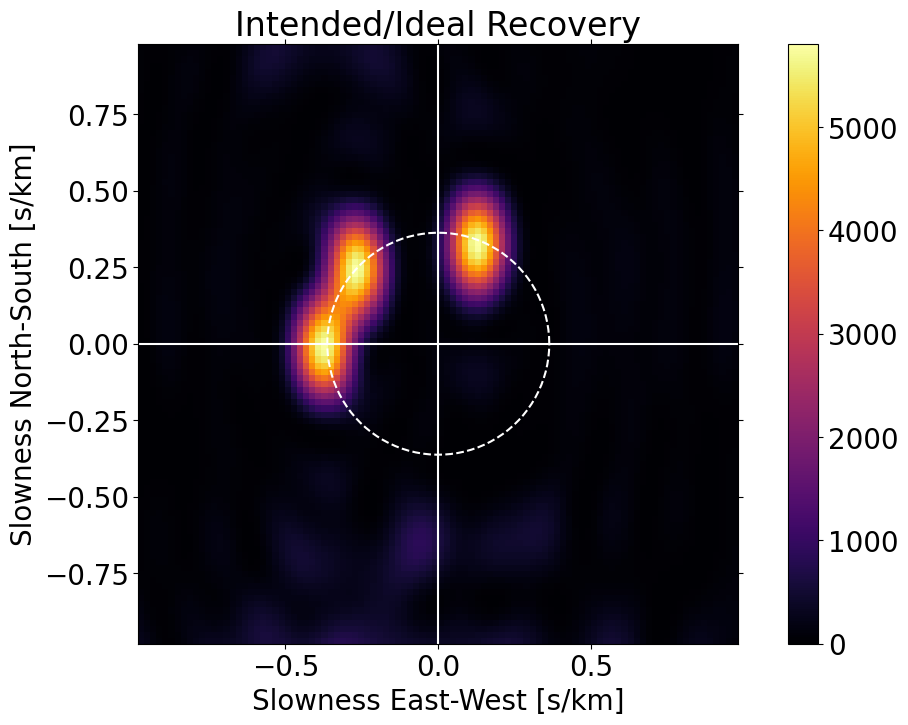

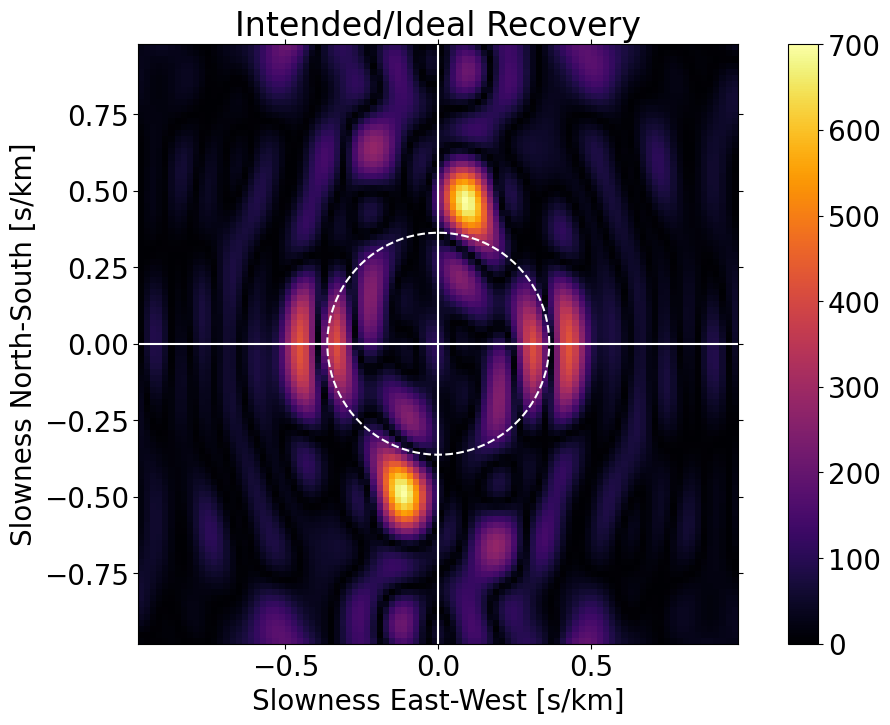

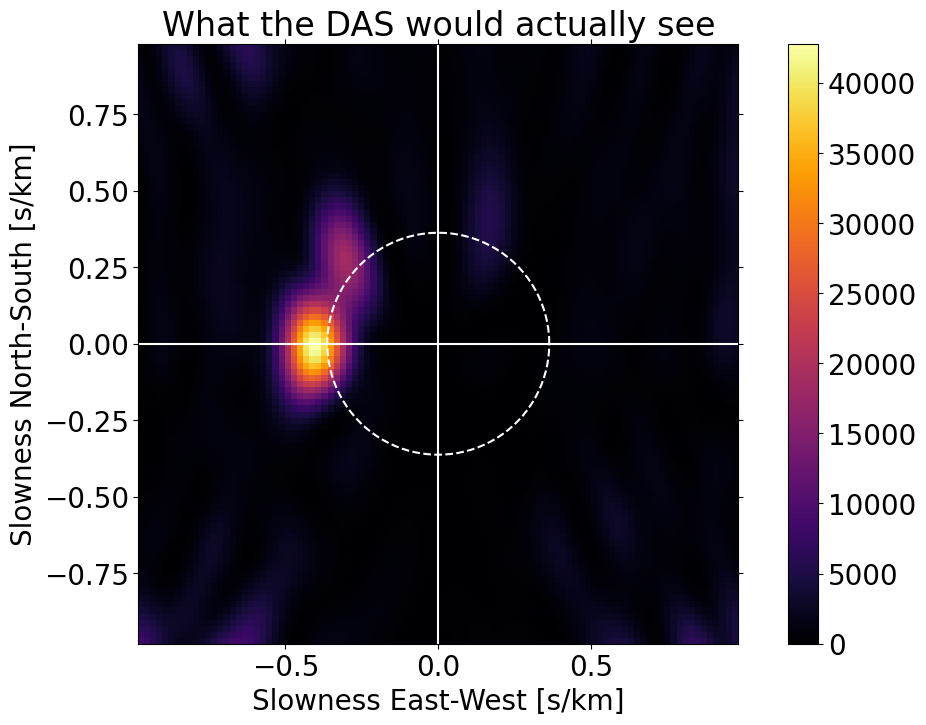

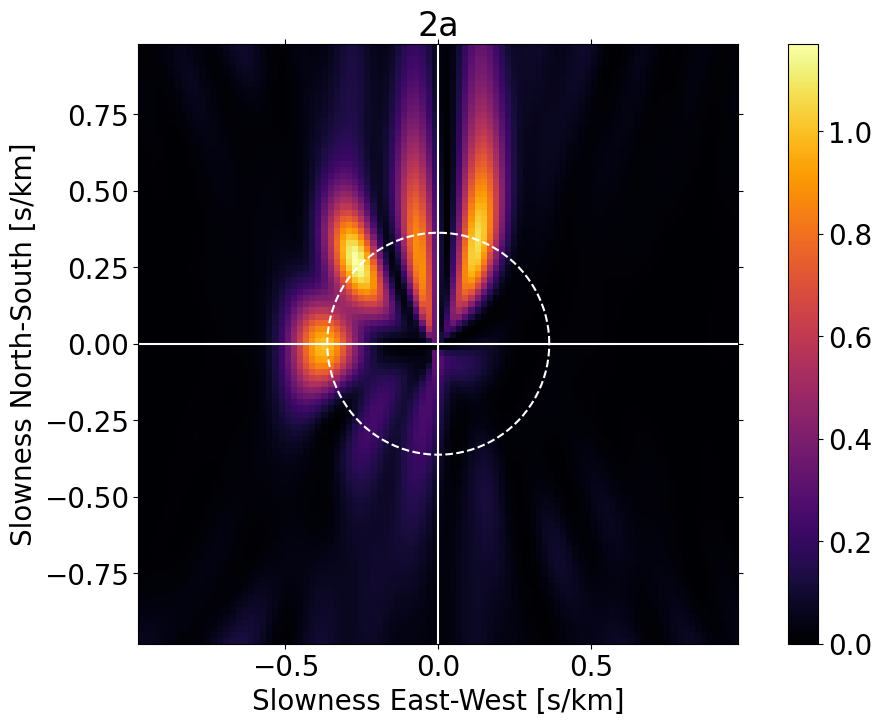

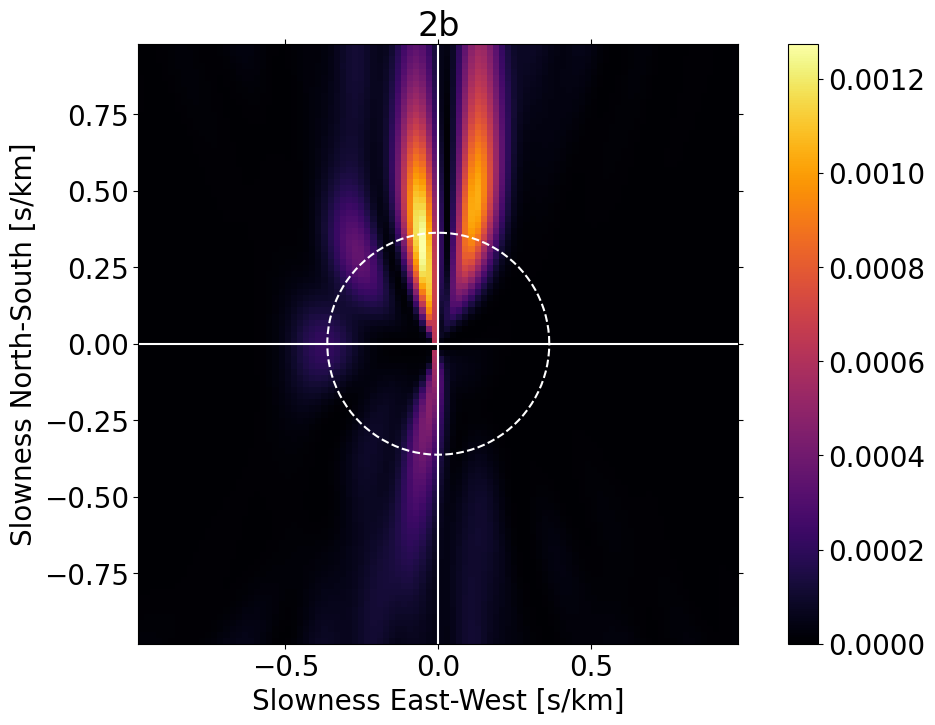

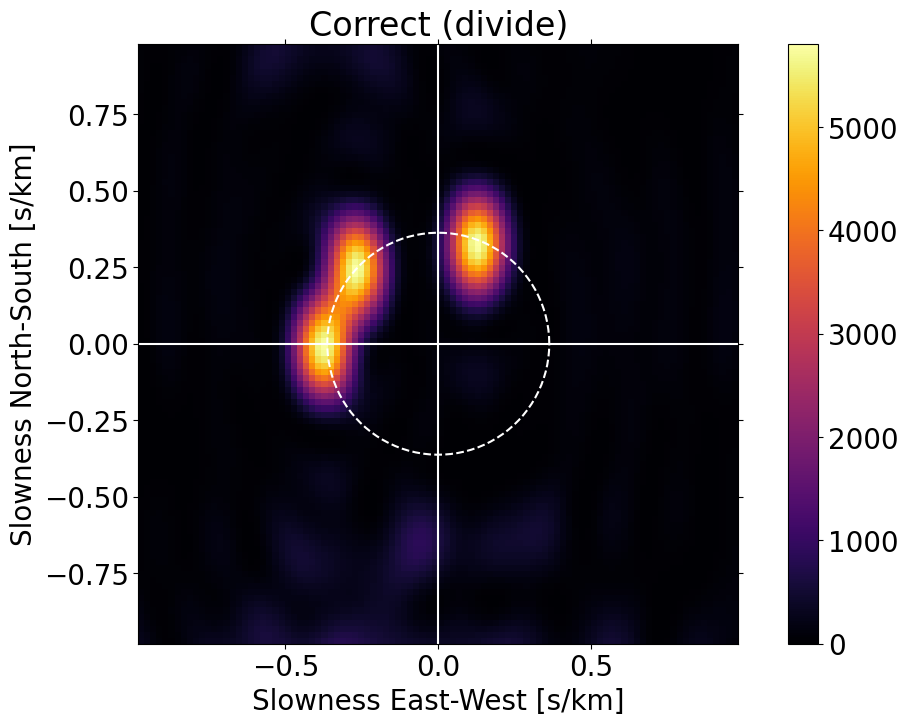

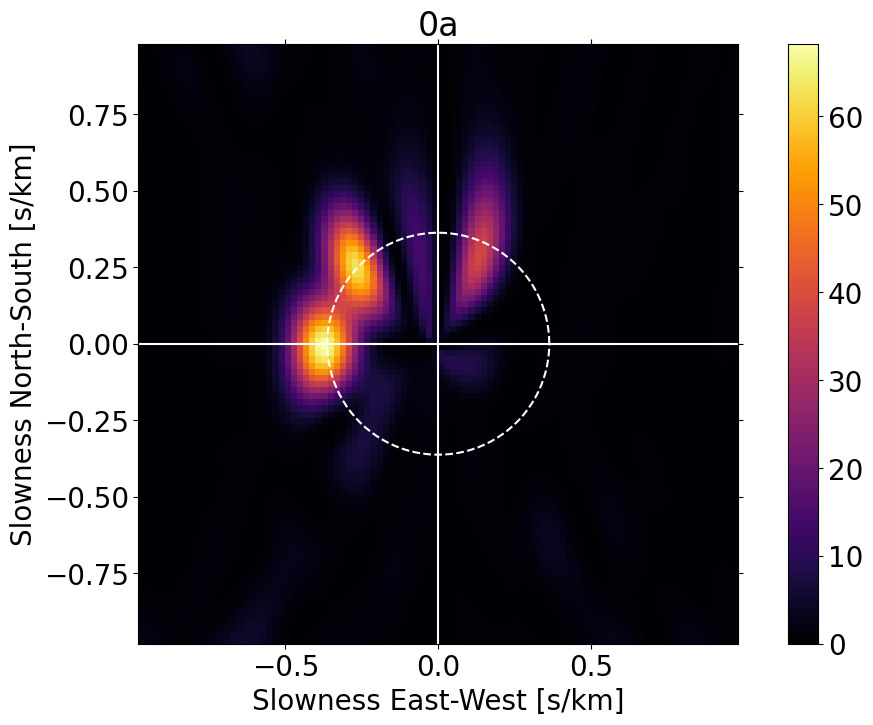

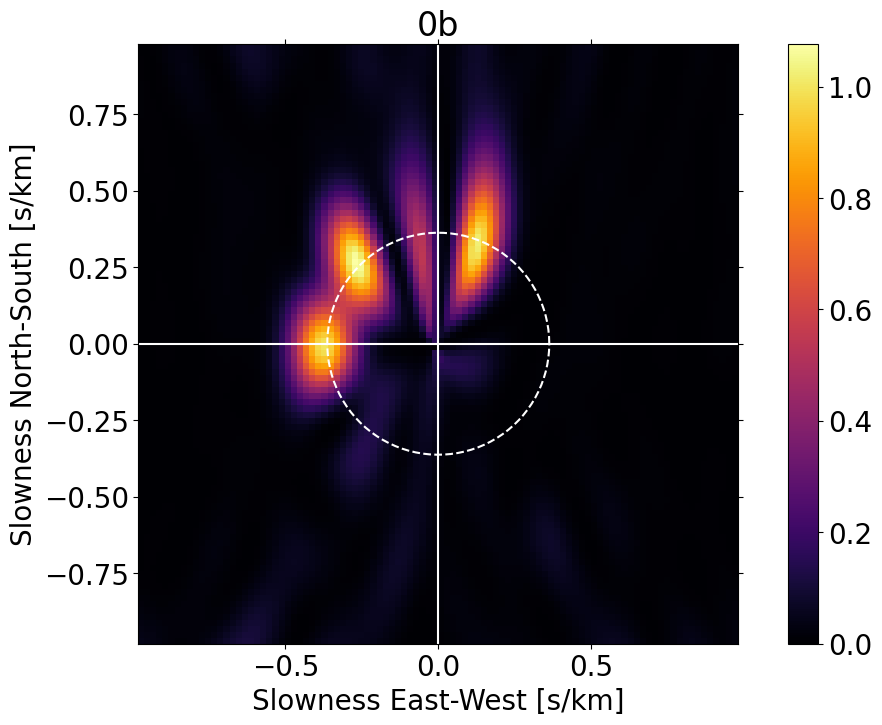

In [17]:
plot_beam(R0_stack, ux, uy, cmin=0, title="Intended/Ideal Recovery", save=0, savename="SARF_1_ideal.pdf")

plot_beam(RD_stack, ux, uy, cmin=0, title="What the DAS would actually see", save=0, savename="SARF_2_actually.pdf")
# plot_beam(R2_stack, ux, uy, cmin=0, title="Weight (multiply)", save=0, savename="SARF_3_weight.pdf")
plot_beam(R2a_stack, ux, uy, cmin=0, title="2a", save=0, savename="SARF_3_weight.pdf")
plot_beam(R2b_stack, ux, uy, cmin=0, title="2b", save=0, savename="SARF_3_2b.pdf")
plot_beam(R2i_stack, ux, uy, cmin=0, title="Correct (divide)", save=0, savename="SARF_3_correct.pdf")

plot_beam(R0a_stack, ux, uy, cmin=0, title="0a", save=0, savename="SARF_3_norm1.pdf")
plot_beam(R0b_stack, ux, uy, cmin=0, title="0b", save=0, savename="SARF_3_norm2.pdf")





# plot_beam(R0c_stack, ux, uy, cmin=0, title="0c", save=0, savename="SARF_3_weight.pdf")